# Chapter 7. Hypothesis and Inference

In [1]:
import sys, os
sys.path.append(os.path.join('..','code-python3'))

%matplotlib inline
import matplotlib.pyplot as plt
from probability import normal_cdf, inverse_normal_cdf
import math, random

## Example: Flipping a Coin

In [2]:
def normal_approximation_to_binomial(n, p):
    """finds mu and sigma corresponding to a Binomial(n, p)"""
    mu = p * n
    sigma = math.sqrt(p * (1 - p) * n)
    return mu, sigma

#####
#
# probabilities a normal lies in an interval
#
######

# the normal cdf _is_ the probability the variable is below a threshold
normal_probability_below = normal_cdf

# it's above the threshold if it's not below the threshold
def normal_probability_above(lo, mu=0, sigma=1):
    return 1 - normal_cdf(lo, mu, sigma)

# it's between if it's less than hi, but not less than lo
def normal_probability_between(lo, hi, mu=0, sigma=1):
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)

# it's outside if it's not between
def normal_probability_outside(lo, hi, mu=0, sigma=1):
    return 1 - normal_probability_between(lo, hi, mu, sigma)

######
#
#  normal bounds
#
######


def normal_upper_bound(probability, mu=0, sigma=1):
    """returns the z for which P(Z <= z) = probability"""
    return inverse_normal_cdf(probability, mu, sigma)

def normal_lower_bound(probability, mu=0, sigma=1):
    """returns the z for which P(Z >= z) = probability"""
    return inverse_normal_cdf(1 - probability, mu, sigma)

def normal_two_sided_bounds(probability, mu=0, sigma=1):
    """returns the symmetric (about the mean) bounds
    that contain the specified probability"""
    tail_probability = (1 - probability) / 2

    # upper bound should have tail_probability above it
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)

    # lower bound should have tail_probability below it
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)

    return lower_bound, upper_bound

In [3]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
print("mu_0", mu_0)
print("sigma_0", sigma_0)
print("normal_two_sided_bounds(0.95, mu_0, sigma_0)", normal_two_sided_bounds(0.95, mu_0, sigma_0))

mu_0 500.0
sigma_0 15.811388300841896
normal_two_sided_bounds(0.95, mu_0, sigma_0) (469.01026640487555, 530.9897335951244)


In [4]:
print("power of a test")

print("95% bounds based on assumption p is 0.5")

lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)
print("lo", lo)
print("hi", hi)

print("actual mu and sigma based on p = 0.55")
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)
print("mu_1", mu_1)
print("sigma_1", sigma_1)

# a type 2 error means we fail to reject the null hypothesis
# which will happen when X is still in our original interval
type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)
power = 1 - type_2_probability # 0.887

print("type 2 probability", type_2_probability)
print("power", power)

power of a test
95% bounds based on assumption p is 0.5
lo 469.01026640487555
hi 530.9897335951244
actual mu and sigma based on p = 0.55
mu_1 550.0
sigma_1 15.732132722552274
type 2 probability 0.11345199870463285
power 0.8865480012953671


In [5]:
print("one-sided test")
hi = normal_upper_bound(0.95, mu_0, sigma_0)
print("hi", hi) # is 526 (< 531, since we need more probability in the upper tail)
type_2_probability = normal_probability_below(hi, mu_1, sigma_1)
power = 1 - type_2_probability # = 0.936
print("type 2 probability", type_2_probability)
print("power", power)

one-sided test
hi 526.0073585242053
type 2 probability 0.06362051966928273
power 0.9363794803307173


In [6]:
def two_sided_p_value(x, mu=0, sigma=1):
    if x >= mu:
        # if x is greater than the mean, the tail is above x
        return 2 * normal_probability_above(x, mu, sigma)
    else:
        # if x is less than the mean, the tail is below x
        return 2 * normal_probability_below(x, mu, sigma)

In [7]:
print("two_sided_p_value(529.5, mu_0, sigma_0)", two_sided_p_value(529.5, mu_0, sigma_0))

two_sided_p_value(529.5, mu_0, sigma_0) 0.06207721579598857


In [8]:
def count_extreme_values():
    extreme_value_count = 0
    for _ in range(100000):
        num_heads = sum(1 if random.random() < 0.5 else 0    # count # of heads
                        for _ in range(1000))                # in 1000 flips
        if num_heads >= 530 or num_heads <= 470:             # and count how often
            extreme_value_count += 1                         # the # is 'extreme'

    return extreme_value_count / 100000

upper_p_value = normal_probability_above
lower_p_value = normal_probability_below

In [9]:
print("two_sided_p_value(531.5, mu_0, sigma_0)", two_sided_p_value(531.5, mu_0, sigma_0))

print("upper_p_value(525, mu_0, sigma_0)", upper_p_value(525, mu_0, sigma_0))
print("upper_p_value(527, mu_0, sigma_0)", upper_p_value(527, mu_0, sigma_0))

two_sided_p_value(531.5, mu_0, sigma_0) 0.046345287837786575
upper_p_value(525, mu_0, sigma_0) 0.056923149003329065
upper_p_value(527, mu_0, sigma_0) 0.04385251499101195


## P-hacking

In [10]:
def run_experiment():
    """flip a fair coin 1000 times, True = heads, False = tails"""
    return [random.random() < 0.5 for _ in range(1000)]

def reject_fairness(experiment):
    """using the 5% significance levels"""
    num_heads = len([flip for flip in experiment if flip])
    return num_heads < 469 or num_heads > 531

In [11]:
print("P-hacking")

random.seed(0)
experiments = [run_experiment() for _ in range(1000)]
num_rejections = len([experiment
                      for experiment in experiments
                      if reject_fairness(experiment)])

print(num_rejections, "rejections out of 1000")

P-hacking
46 rejections out of 1000


## Running an A/B test

In [12]:
def estimated_parameters(N, n):
    p = n / N
    sigma = math.sqrt(p * (1 - p) / N)
    return p, sigma

def a_b_test_statistic(N_A, n_A, N_B, n_B):
    p_A, sigma_A = estimated_parameters(N_A, n_A)
    p_B, sigma_B = estimated_parameters(N_B, n_B)
    return (p_B - p_A) / math.sqrt(sigma_A ** 2 + sigma_B ** 2)

In [13]:
print("A/B testing")
z = a_b_test_statistic(1000, 200, 1000, 180)
print("a_b_test_statistic(1000, 200, 1000, 180)", z)
print("p-value", two_sided_p_value(z))
z = a_b_test_statistic(1000, 200, 1000, 150)
print("a_b_test_statistic(1000, 200, 1000, 150)", z)
print("p-value", two_sided_p_value(z))

A/B testing
a_b_test_statistic(1000, 200, 1000, 180) -1.1403464899034472
p-value 0.254141976542236
a_b_test_statistic(1000, 200, 1000, 150) -2.948839123097944
p-value 0.003189699706216853


## Bayesian Inference

In [14]:
def B(alpha, beta):
    """a normalizing constant so that the total probability is 1"""
    return math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta)

def beta_pdf(x, alpha, beta):
    if x < 0 or x > 1:          # no weight outside of [0, 1]
        return 0
    return x ** (alpha - 1) * (1 - x) ** (beta - 1) / B(alpha, beta)

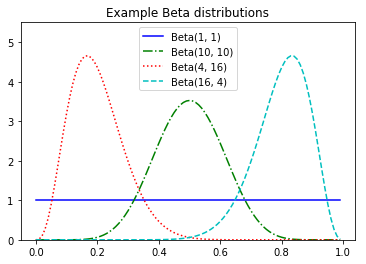

In [15]:
xs = [i/100 for i in range(100)]
plt.plot(xs, [beta_pdf(x, 1, 1) for x in xs], 'b-', label='Beta(1, 1)')
plt.plot(xs, [beta_pdf(x, 10, 10) for x in xs], 'g-.', label='Beta(10, 10)')
plt.plot(xs, [beta_pdf(x, 4, 16) for x in xs], 'r:', label='Beta(4, 16)')
plt.plot(xs, [beta_pdf(x, 16, 4) for x in xs], 'c--', label='Beta(16, 4)')
plt.ylim(0, 5.5)
plt.legend(loc=9)
plt.title('Example Beta distributions')

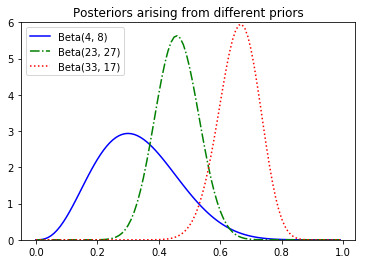

In [16]:
xs = [i/100 for i in range(100)]
plt.plot(xs, [beta_pdf(x, 4, 8) for x in xs], 'b-', label='Beta(4, 8)')
plt.plot(xs, [beta_pdf(x, 23, 27) for x in xs], 'g-.', label='Beta(23, 27)')
plt.plot(xs, [beta_pdf(x, 33, 17) for x in xs], 'r:', label='Beta(33, 17)')
plt.ylim(0, 6)
plt.legend(loc=2)
plt.title('Posteriors arising from different priors')